# Purpose

Figure out pulling location IDs for only DCFC US (non-Tesla to start with) in the US. Need location IDs to efficiently scrape Plugshare with some of our other code.

# Imports

In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
from rich import print
import os
import pandas as pd
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
from typing import List, Union, Set

from evlens.data.plugshare import Scraper

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException, ElementNotInteractableException

# Electrify America in Springfield, VA mall parking lot
TEST_LOCATION = 252784

from dotenv import load_dotenv
load_dotenv(override=True)

from evlens.logs import setup_logger
logger = setup_logger("Notebook-0.2")
logger.info("TEST!")

2024-06-22_T19_58_32EDT: INFO (Notebook-0.2:L31) - TEST!


# Set up our constants

# Grabbing the data from the first page

First let's focus on simply pulling location IDs from the pins we see on the default map view before we get into the details of rastering across the US.

## Helper Functions

In [ ]:
URL = "https://developer.plugshare.com/embed"

In [3]:


class SeleniumDriver():
    
    def __init__(self, timeout: int = 3):
        self.timeout = timeout
        self.chrome_options = Options()
            
        # Removes automation infobar
        self.chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])


        # Get rid of kruft that will slow us down
        self.chrome_options.add_argument("--disable-extensions")
        self.chrome_options.add_argument("--disable-notifications")

        # Turn off geolocation to speed things up
        prefs = {"profile.default_content_setting_values.geolocation":2} 
        self.chrome_options.add_experimental_option("prefs", prefs)
        

        self.driver = webdriver.Chrome(options=self.chrome_options)
        self.driver.maximize_window()
        self.wait = WebDriverWait(self.driver, timeout)

In [4]:
def get_elements(driver, criterion, xpath: str):
    elements = driver.find_elements(criterion, xpath)
    if len(elements) == 1:
        logger.info("Found only one element")
        return elements[0]
    elif len(elements) == 0:
        logger.error("Found no elements")
        return None
    
    logger.info(f"Found {len(elements)} elements")
    return elements

## Parsing It

In [23]:
from time import time
from evlens.data.plugshare import LocationIDScraper, SearchCriterion

from datetime import date
TODAY_STRING = date.today().strftime("%m-%d-%Y")

# Moynihan Train Station - should have only one pin for CCS
TEST_COORDS = (40.7525834,-73.9999498) # Lat, long
RADIUS = 1 # miles
SLEEP_FOR_IFRAME_PAN = 1.5

start_time = time()
lis = LocationIDScraper(
    f"../data/external/plugshare/{TODAY_STRING}/",
    timeout=3,
    headless=False
)

sc = SearchCriterion(
    TEST_COORDS[0],
    TEST_COORDS[1],
    RADIUS,
    SLEEP_FOR_IFRAME_PAN
)
df_location_ids = lis.run([sc])

print(f"Took {time() - start_time} seconds to execute")

# Should return [563873, 574882]
df_location_ids

2024-06-23_T17_30_38EDT: INFO (evlens.data.plugshare:L563) - Beginning location ID scraping!
Searching map tiles: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
2024-06-23_T17_30_46EDT: INFO (evlens.data.plugshare:L330) - Saving checkpoint 'df_location_ids'...
2024-06-23_T17_30_46EDT: INFO (evlens.data.plugshare:L338) - Save complete!
2024-06-23_T17_30_46EDT: INFO (evlens.data.plugshare:L604) - All location IDs scraped (that we could)!


Took 8.7657949924469 seconds to execute

,parsed_datetime,plug_types_searched,location_id,search_cell_latitude,search_cell_longitude
0,06-23-2024_T21_30_44,[SAE Combo DC CCS],563873,40.752583,-73.99995
1,06-23-2024_T21_30_44,[SAE Combo DC CCS],574882,40.752583,-73.99995


The current problem: the pin popup shoves the viewport so I lose track of my pin elements and they go stale. BUT if I zoom out to make room, the pin elements *also* go stale. 

* I think I have to:
    1. Click the first pin and record its info
    2. Re-query the map (UGH time consuming)
    3. Click the next pin and record
    4. Rinse and repeat for all pins I originally found...

# Gridding Up the US

The idea is that we'll be able to draw a line around the country of interest (USA for now) and then build hexagonal or some other kind of grid of size `radius` such that we can iterate through one at a time.

Each grid tile will need a lat/long coordinate as its center to make it useful.

In [32]:
import geopandas as gpd
import h3pandas

# Prepare data
# gdf = gpd.read_file('../references/2010_us_outline_5m.json')
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf

/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_63722/4069941300.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


<Axes: >

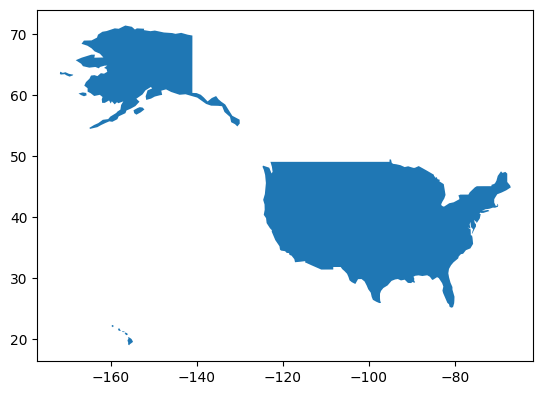

In [34]:
gdf = gdf.loc[gdf['name'].eq('United States of America')]
gdf.plot()

<Axes: >

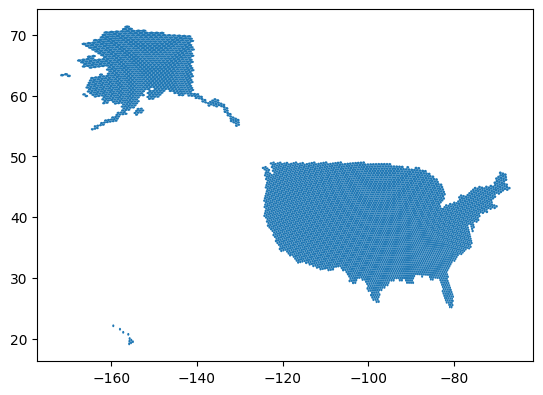

In [37]:
resolution = 4

# Resample to H3 cells
gdf_h3 = gdf.h3.polyfill_resample(resolution)
gdf_h3.plot()

In [54]:
from typing import Literal
from pyproj import Geod

def find_area_of_cell(cell, unit: Union[Literal['mi^2'], Literal['m^2']] = 'mi^2') -> float:
    geod = Geod(ellps="WGS84")
    geod_area = abs(geod.geometry_area_perimeter(cell)[0]) # m^2
    if unit == 'mi^2':
        geod_area /= 2.59E6
        
    return geod_area

In [62]:
# How to set the resolution to get a median area of 1 mi^2?
resolution = 7

gdf_h3 = gdf.h3.polyfill_resample(resolution)
cell_areas = gdf_h3.geometry.apply(find_area_of_cell)
cell_areas.describe()

count    1.812316e+06
mean     2.026008e+00
std      1.589585e-01
min      1.565716e+00
25%      1.918172e+00
50%      2.026387e+00
75%      2.137517e+00
max      2.360981e+00
Name: geometry, dtype: float64

In [72]:
gdf_h3['cell_area'] = cell_areas
gdf_h3 = gdf_h3[['geometry', 'cell_area']]

In [73]:
gdf_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1812316 entries, 872631cacffffff to 872b99662ffffff
Data columns (total 2 columns):
 #   Column     Dtype   
---  ------     -----   
 0   geometry   geometry
 1   cell_area  float64 
dtypes: float64(1), geometry(1)
memory usage: 106.0+ MB


In [80]:
# Figure out how to grab the lat/long centroid of every cell
def get_lat_long_of_cell(cell):
    centroid_xy = cell.centroid.coords.xy
    longitude = centroid_xy[0][0]
    latitude = centroid_xy[1][0]
    
    return latitude, longitude

get_lat_long_of_cell(gdf_h3.geometry.sample(1).iloc[0])

(28.841314897402793, -96.2376026059896)

In [81]:
gdf_h3['lat_long'] = gdf_h3.geometry.apply(get_lat_long_of_cell)
gdf_h3['lat_long'].sample(1)

/Users/davemcrench/Projects/evlens/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


h3_polyfill
872a96b81ffffff    (40.98842628908962, -84.46774222450958)
Name: lat_long, dtype: object

In [87]:
gdf_h3_lat_long = pd.DataFrame(gdf_h3.lat_long.tolist()).rename(columns={0: 'latitude', 1: 'longitude'})

for col in ['latitude', 'longitude']:
    gdf_h3[col] = gdf_h3_lat_long[col].values
    
gdf_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1812316 entries, 872631cacffffff to 872b99662ffffff
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   geometry   geometry
 1   cell_area  float64 
 2   lat_long   object  
 3   latitude   float64 
 4   longitude  float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 147.5+ MB


/Users/davemcrench/Projects/evlens/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [88]:
gdf_h3.isnull().sum()

geometry     0
cell_area    0
lat_long     0
latitude     0
longitude    0
dtype: int64

In [94]:
gdf_h3.to_pickle('../data/processed/h3_hexagons_usa.pkl')

In [98]:
gdf_h3[['latitude', 'longitude', 'cell_area']].rename(columns={'cell_area': 'cell_area_sq_miles'}).reset_index(drop=True).to_pickle('../references/h3_hexagon_coordinates.pkl')

In [96]:
gdf_h3[['latitude', 'longitude', 'cell_area']].reset_index(drop=True)

,latitude,longitude,cell_area
0,45.464431,-98.886784,2.011903
1,39.455015,-74.652521,1.956755
2,39.796307,-82.959108,1.960595
3,65.729917,-153.760950,1.961247
4,34.999866,-113.618679,2.262247
...,...,...,...
1812311,44.034825,-95.046059,2.015590
1812312,58.232777,-134.617931,1.643765
1812313,47.504406,-103.981484,1.995752
1812314,40.329259,-82.095223,1.984732
